In [27]:
#mount drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [28]:
cd '/content/drive/MyDrive/TFG-AnalisisResultados'

/content/drive/MyDrive/TFG-AnalisisResultados


In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob

# HV improvement

We will locate the best run per configuration by looking for the best final HV. That will be our representative runs for HV, final Pareto front visualization and evolution of objectives.

## LD


In [30]:
sgp = pd.read_parquet('./LD_SGP_combined_logs.parquet')
sgp.acquisition = sgp.acquisition.astype(str)
sgp = sgp.loc[sgp['acquisition'] == 'qParEGO', :]
for seed, df in sgp.groupby('seed'):
  df = df.loc[df['iteration'] == df['iteration'].max(), :]
  df = df.loc[df['hypervolume'] == df['hypervolume'].max(), :]
  print(f"Seed: {seed} with HV {df['hypervolume'].values}")

Seed: 0 with HV [138.74714272]
Seed: 1 with HV [134.16619893]
Seed: 2 with HV [137.83287826]
Seed: 3 with HV [136.49324299]
Seed: 4 with HV [140.81990521]


In [31]:
mgp = pd.read_parquet('./LD_MGP_combined_logs.parquet')
mgp.acquisition = mgp.acquisition.astype(str)
mgp = mgp.loc[mgp['acquisition'] == 'qParEGO', :]
for seed, df in mgp.groupby('seed'):
  df = df.loc[df['iteration'] == df['iteration'].max(), :]
  df = df.loc[df['hypervolume'] == df['hypervolume'].max(), :]
  print(f"Seed: {seed} with HV {df['hypervolume'].values}")

Seed: 0 with HV [139.13494941]
Seed: 1 with HV [133.20369464]
Seed: 2 with HV [138.34770312]
Seed: 3 with HV [136.82518242]
Seed: 4 with HV [141.62185451]


In [32]:
mgp = pd.read_parquet('./LD_MGPR1_combined_logs.parquet')
mgp.acquisition = mgp.acquisition.astype(str)
mgp = mgp.loc[mgp['acquisition'] == 'qParEGO', :]
for seed, df in mgp.groupby('seed'):
  df = df.loc[df['iteration'] == df['iteration'].max(), :]
  df = df.loc[df['hypervolume'] == df['hypervolume'].max(), :]
  print(f"Seed: {seed} with HV {df['hypervolume'].values}")

Seed: 0 with HV [139.4545086]
Seed: 1 with HV [133.42507383]
Seed: 2 with HV [137.90930359]
Seed: 3 with HV [135.05477707]
Seed: 4 with HV [140.32269782]


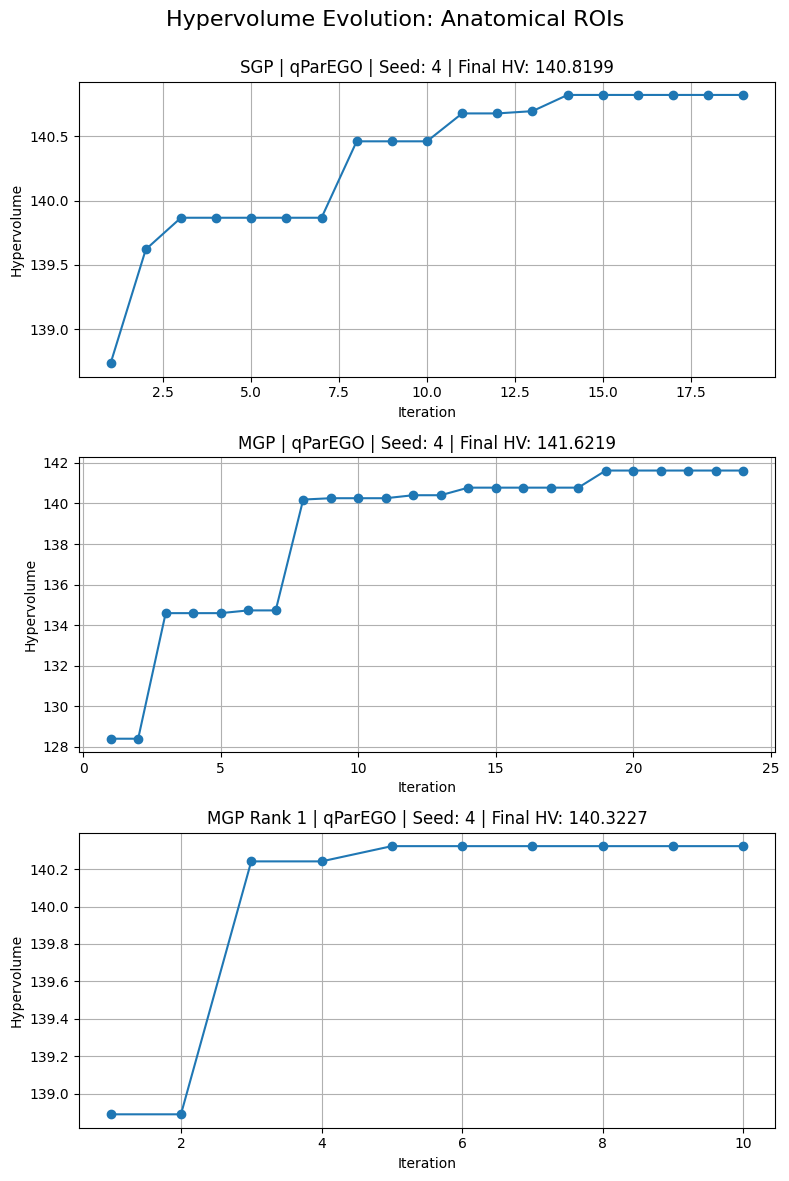

In [33]:
import pandas as pd
import matplotlib.pyplot as plt

# Load data for each model
sgp = pd.read_parquet('./LD_SGP_combined_logs.parquet')
mgp = pd.read_parquet('./LD_MGP_combined_logs.parquet')
mgp1 = pd.read_parquet('./LD_MGPR1_combined_logs.parquet')

# Filter by acquisition function
sgp = sgp[sgp['acquisition'].astype(str) == 'qParEGO']
mgp = mgp[mgp['acquisition'].astype(str) == 'qParEGO']
mgp1 = mgp1[mgp1['acquisition'].astype(str) == 'qParEGO']

def get_best_run(df, model_name):
    best_seed = None
    best_final_hv = -float('inf')
    best_run_df = None

    for seed, group in df.groupby('seed'):
        max_iter = group['iteration'].max()
        final_hv = group[group['iteration'] == max_iter]['hypervolume'].max()

        if final_hv > best_final_hv:
            best_final_hv = final_hv
            best_seed = seed
            best_run_df = group[group['seed'] == seed]

    return best_run_df.sort_values('iteration'), best_seed, best_final_hv

# Get best runs
sgp_best, sgp_seed, sgp_hv = get_best_run(sgp, 'SGP')
dgp_best, dgp_seed, dgp_hv = get_best_run(mgp, 'DGP')
bnn_best, bnn_seed, bnn_hv = get_best_run(mgp1, 'BNN')

# Plotting (no sharex)
fig, axs = plt.subplots(3, 1, figsize=(8, 12))  # Removed sharex=True

models = ['SGP', 'MGP', 'MGP Rank 1']
runs = [sgp_best, dgp_best, bnn_best]
seeds = [sgp_seed, dgp_seed, bnn_seed]
hvs = [sgp_hv, dgp_hv, bnn_hv]

for ax, run_df, model, seed, hv in zip(axs, runs, models, seeds, hvs):
    acquisition = run_df['acquisition'].iloc[0]  # same for entire run
    ax.plot(run_df['iteration'], run_df['hypervolume'], marker='o')
    ax.set_title(f'{model} | {acquisition} | Seed: {seed} | Final HV: {hv:.4f}')
    ax.set_ylabel('Hypervolume')
    ax.set_xlabel('Iteration')
    ax.grid(True)

plt.suptitle("Hypervolume Evolution: Anatomical ROIs\n", fontsize=16)
plt.tight_layout()
plt.show()

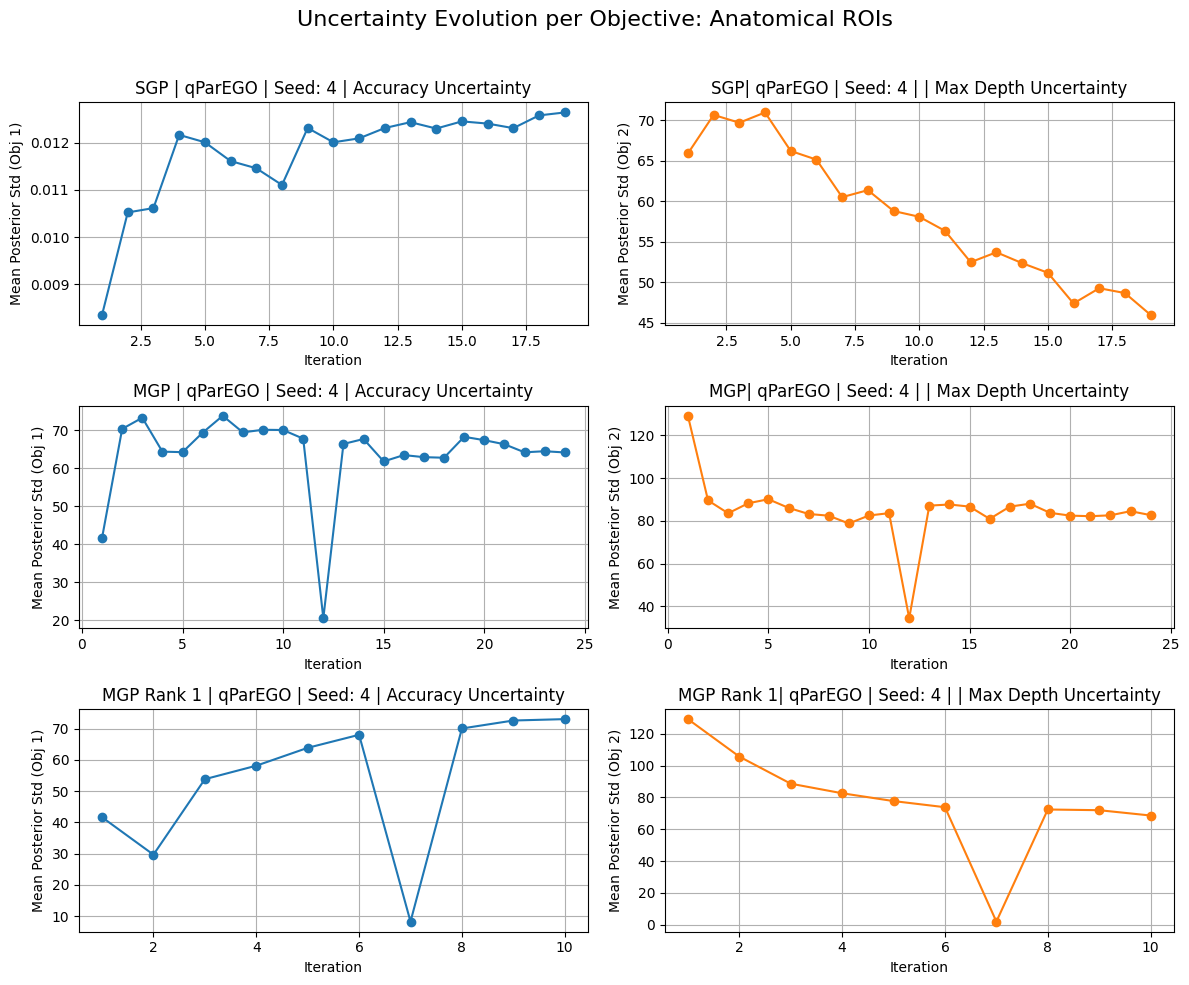

In [34]:

fig, axs = plt.subplots(3, 2, figsize=(12, 10))  # Rows = models, 2 columns for objectives

for row, (run_df, model, seed) in enumerate(zip(runs, models, seeds)):
    acquisition = run_df['acquisition'].iloc[0]  # same for entire run

    run_df = run_df[run_df["posterior_std"].notnull()]

    # Containers for each objective
    iter_to_obj1_std = {}
    iter_to_obj2_std = {}

    for _, row_data in run_df.iterrows():
        iteration = row_data["iteration"]
        stds = np.stack(row_data["posterior_std"])  # Shape: (batch_size, 2)

        obj1_mean = np.mean(stds[:, 0])  # Accuracy objective
        obj2_mean = np.mean(stds[:, 1])  # Max depth objective

        iter_to_obj1_std.setdefault(iteration, []).append(obj1_mean)
        iter_to_obj2_std.setdefault(iteration, []).append(obj2_mean)

    # Aggregate mean per iteration
    iterations = sorted(iter_to_obj1_std.keys())
    obj1_means = [np.mean(iter_to_obj1_std[i]) for i in iterations]
    obj2_means = [np.mean(iter_to_obj2_std[i]) for i in iterations]

    # Plot Objective 1 (e.g., Accuracy)
    axs[row, 0].plot(iterations, obj1_means, marker='o', color='tab:blue')
    axs[row, 0].set_title(f'{model} | {acquisition} | Seed: {seed} | Accuracy Uncertainty')

    axs[row, 0].set_ylabel('Mean Posterior Std (Obj 1)')
    axs[row, 0].set_xlabel('Iteration')
    axs[row, 0].grid(True)

    # Plot Objective 2 (e.g., Max Depth)
    axs[row, 1].plot(iterations, obj2_means, marker='o', color='tab:orange')
    axs[row, 1].set_title(f'{model}| {acquisition} | Seed: {seed} | | Max Depth Uncertainty')
    axs[row, 1].set_ylabel('Mean Posterior Std (Obj 2)')
    axs[row, 1].set_xlabel('Iteration')
    axs[row, 1].grid(True)

plt.suptitle("Uncertainty Evolution per Objective: Anatomical ROIs", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [35]:
from scipy.spatial.distance import cdist
import numpy as np

def spacing_metric(pareto_front):
    if len(pareto_front) < 2:
        return np.nan  # spacing not defined for 1 or fewer points
    distances = cdist(pareto_front, pareto_front)
    np.fill_diagonal(distances, np.inf)
    nearest_distances = np.min(distances, axis=1)
    mean_d = np.mean(nearest_distances)
    spacing = np.sqrt(np.mean((nearest_distances - mean_d) ** 2))
    return spacing


[[  0.71222811  -9.        ]
 [  0.69874418  -2.        ]
 [  0.71713243 -10.        ]
 [  0.70752811  -7.        ]
 [  0.71960304 -45.        ]]
[[  0.69874418  -2.        ]
 [  0.72384093 -12.        ]]
[[  0.69874418  -2.        ]
 [  0.71752726 -25.        ]
 [  0.70869125 -13.        ]]


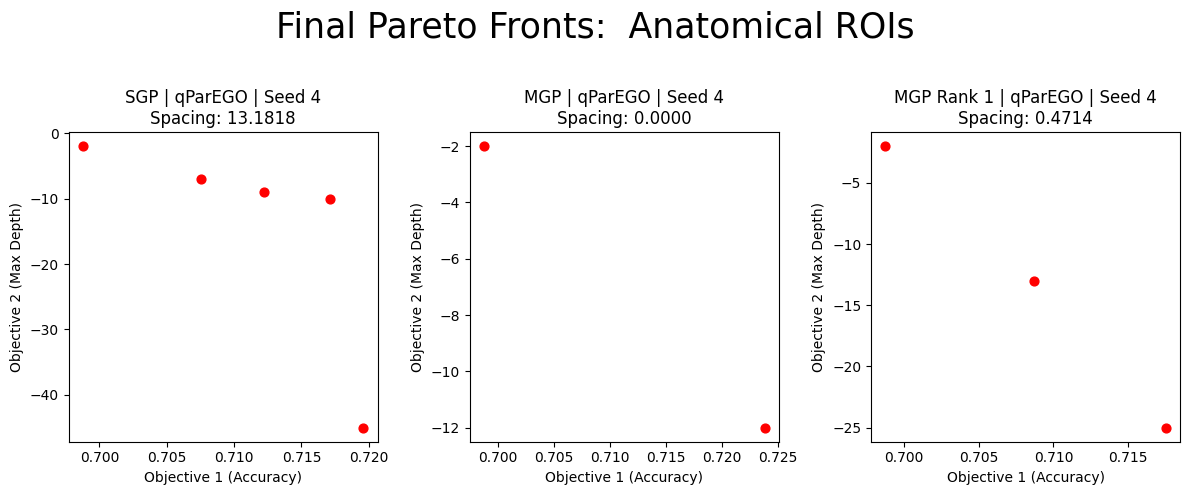

In [36]:
fig, axs = plt.subplots(1,3, figsize=(12, 5))  # 3 subplots in one row

for ax, run_df, model, seed in zip(axs, runs, models, seeds):
    acquisition = run_df['acquisition'].iloc[0]  # same for entire run

    # Get final iteration
    final_row = run_df[run_df['iteration'] == run_df['iteration'].max()].iloc[0]
    pareto = np.stack(final_row["pareto_front"], dtype=float)  # shape: (N, 2)
    print(pareto)
    # Plot in red
    ax.scatter(pareto[:, 0], pareto[:, 1], s=40, color='red')

    # Annotate each point
    # for x, y in pareto:
    #     ax.annotate(f'({x:.2f}, {y:.2f})', (x, y), textcoords="offset pixels", xytext=(5, 5), fontsize=12)

    # Compute spacing
    spacing = spacing_metric(pareto)

    # Title and labels
    ax.set_title(f'{model} | {acquisition} | Seed {seed}\nSpacing: {spacing:.4f}')
    ax.set_xlabel("Objective 1 (Accuracy)")
    ax.set_ylabel("Objective 2 (Max Depth)")

    # No grid
    ax.grid(False)

plt.suptitle("Final Pareto Fronts:  Anatomical ROIs", fontsize=25)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

## LD NEURO


In [37]:
sgp = pd.read_parquet('./LD_NEURO_SGP_combined_logs.parquet')
sgp.acquisition = sgp.acquisition.astype(str)
sgp = sgp.loc[sgp['acquisition'] == 'qParEGO', :]
for seed, df in sgp.groupby('seed'):
  df = df.loc[df['iteration'] == df['iteration'].max(), :]
  df = df.loc[df['hypervolume'] == df['hypervolume'].max(), :]
  print(f"Seed: {seed} with HV {df['hypervolume'].values}")

Seed: 0 with HV [136.4548762]
Seed: 1 with HV [136.11259001]
Seed: 2 with HV [139.1810814]
Seed: 3 with HV [133.65272905]
Seed: 4 with HV [135.20199325]


In [38]:
mgp = pd.read_parquet('./LD_NEURO_MGP_combined_logs.parquet')
mgp.acquisition = mgp.acquisition.astype(str)
mgp = mgp.loc[mgp['acquisition'] == 'qQNEHVI', :]
for seed, df in mgp.groupby('seed'):
  df = df.loc[df['iteration'] == df['iteration'].max(), :]
  df = df.loc[df['hypervolume'] == df['hypervolume'].max(), :]
  print(f"Seed: {seed} with HV {df['hypervolume'].values}")

Seed: 0 with HV [136.25952978]
Seed: 1 with HV [135.75077538]
Seed: 2 with HV [138.12807952]
Seed: 3 with HV [134.90403493]
Seed: 4 with HV [135.76905652]


In [39]:
mgp = pd.read_parquet('./LD_NEURO_MGPR1_combined_logs.parquet')
mgp.acquisition = mgp.acquisition.astype(str)
mgp = mgp.loc[mgp['acquisition'] == 'qQEHVI', :]
for seed, df in mgp.groupby('seed'):
  df = df.loc[df['iteration'] == df['iteration'].max(), :]
  df = df.loc[df['hypervolume'] == df['hypervolume'].max(), :]
  print(f"Seed: {seed} with HV {df['hypervolume'].values}")

Seed: 0 with HV [137.63846841]
Seed: 1 with HV [134.68852044]
Seed: 2 with HV [138.65132405]
Seed: 3 with HV [134.45320439]
Seed: 4 with HV [135.6569428]


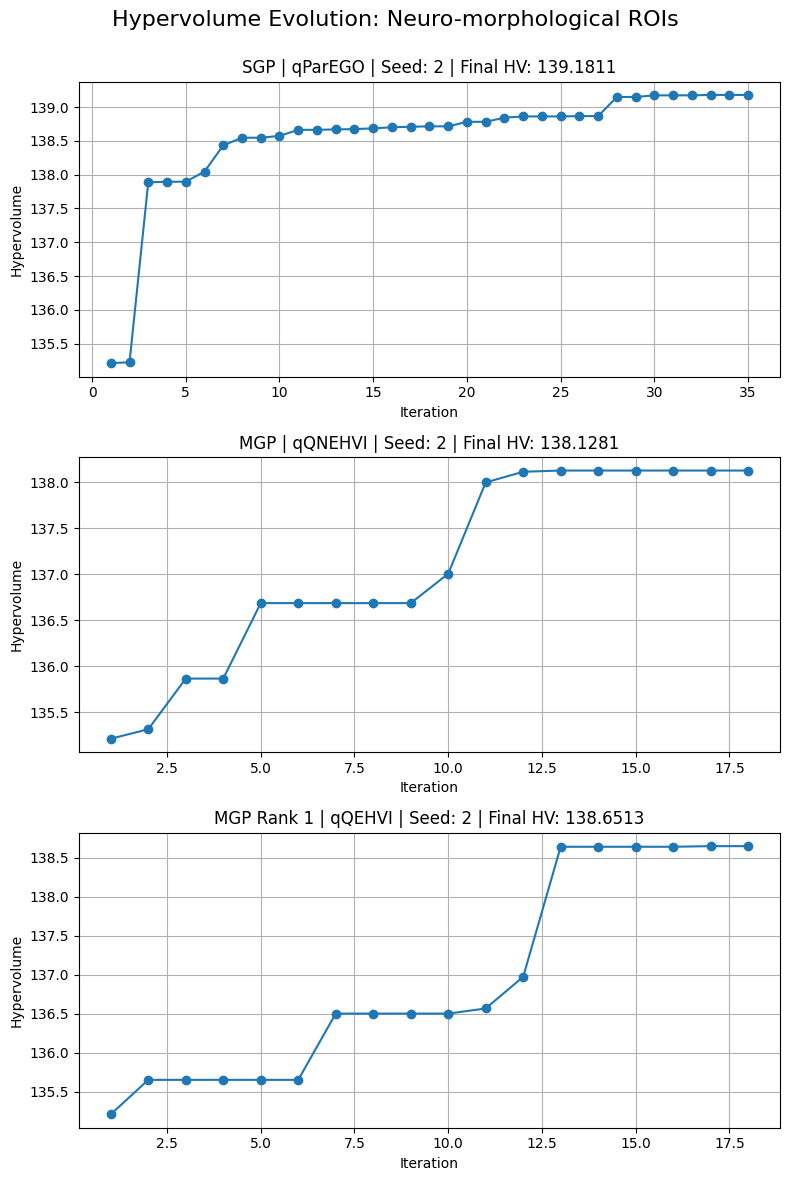

In [40]:
import pandas as pd
import matplotlib.pyplot as plt

# Load data for each model
sgp = pd.read_parquet('./LD_NEURO_SGP_combined_logs.parquet')
mgp = pd.read_parquet('./LD_NEURO_MGP_combined_logs.parquet')
mgp1 = pd.read_parquet('./LD_NEURO_MGPR1_combined_logs.parquet')

# Filter by acquisition function
sgp = sgp[sgp['acquisition'].astype(str) == 'qParEGO']
mgp = mgp[mgp['acquisition'].astype(str) == 'qQNEHVI']
mgp1 = mgp1[mgp1['acquisition'].astype(str) == 'qQEHVI']

def get_best_run(df, model_name):
    best_seed = None
    best_final_hv = -float('inf')
    best_run_df = None

    for seed, group in df.groupby('seed'):
        max_iter = group['iteration'].max()
        final_hv = group[group['iteration'] == max_iter]['hypervolume'].max()

        if final_hv > best_final_hv:
            best_final_hv = final_hv
            best_seed = seed
            best_run_df = group[group['seed'] == seed]

    return best_run_df.sort_values('iteration'), best_seed, best_final_hv

# Get best runs
sgp_best, sgp_seed, sgp_hv = get_best_run(sgp, 'SGP')
dgp_best, dgp_seed, dgp_hv = get_best_run(mgp, 'DGP')
bnn_best, bnn_seed, bnn_hv = get_best_run(mgp1, 'BNN')

# Plotting (no sharex)
fig, axs = plt.subplots(3, 1, figsize=(8, 12))  # Removed sharex=True

models = ['SGP', 'MGP', 'MGP Rank 1']
runs = [sgp_best, dgp_best, bnn_best]
seeds = [sgp_seed, dgp_seed, bnn_seed]
hvs = [sgp_hv, dgp_hv, bnn_hv]

for ax, run_df, model, seed, hv in zip(axs, runs, models, seeds, hvs):
    acquisition = run_df['acquisition'].iloc[0]  # same for entire run
    ax.plot(run_df['iteration'], run_df['hypervolume'], marker='o')
    ax.set_title(f'{model} | {acquisition} | Seed: {seed} | Final HV: {hv:.4f}')
    ax.set_ylabel('Hypervolume')
    ax.set_xlabel('Iteration')
    ax.grid(True)

plt.suptitle("Hypervolume Evolution: Neuro-morphological ROIs\n", fontsize=16)
plt.tight_layout()
plt.show()

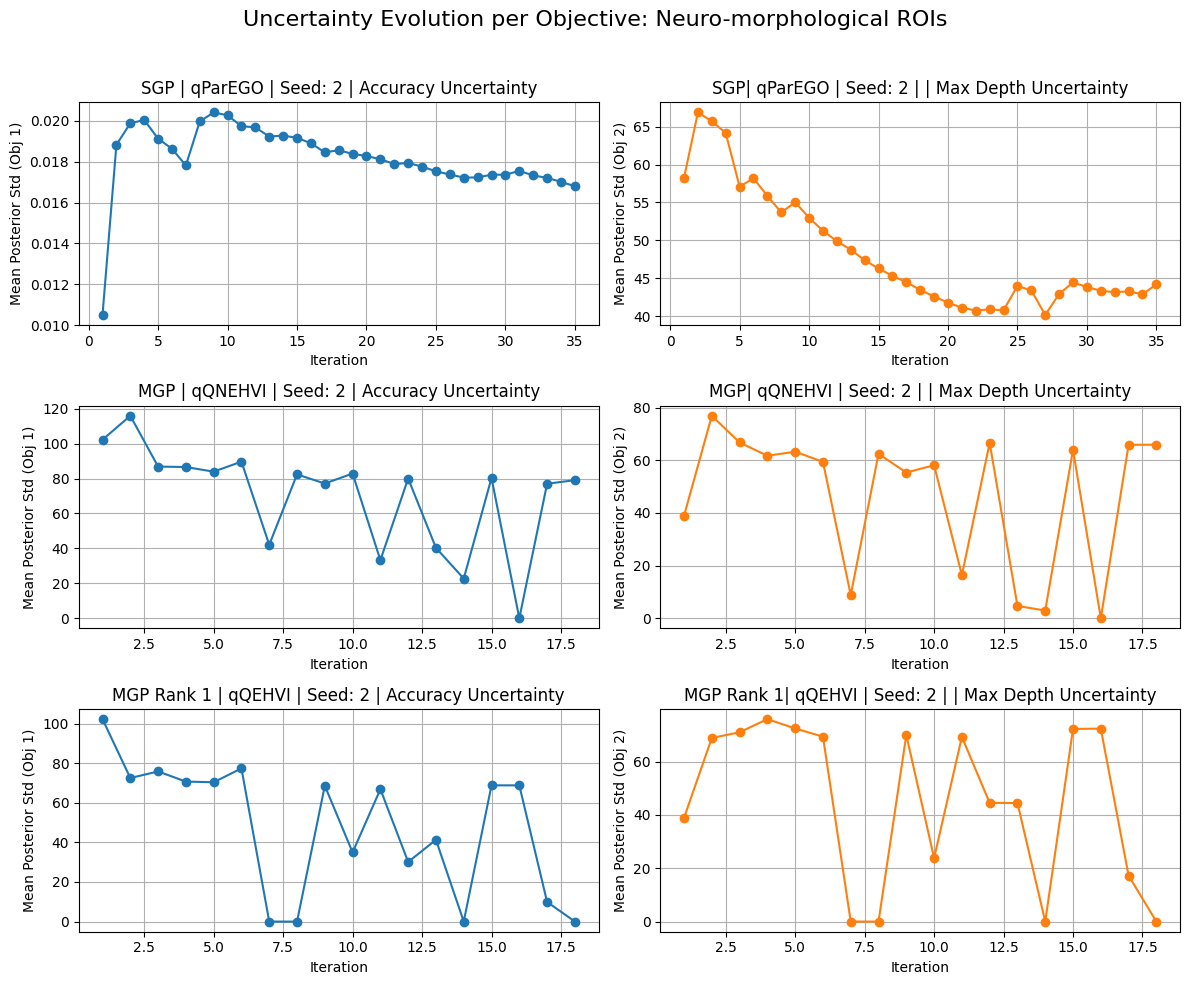

In [41]:

fig, axs = plt.subplots(3, 2, figsize=(12, 10))  # Rows = models, 2 columns for objectives

for row, (run_df, model, seed) in enumerate(zip(runs, models, seeds)):
    acquisition = run_df['acquisition'].iloc[0]  # same for entire run

    run_df = run_df[run_df["posterior_std"].notnull()]

    # Containers for each objective
    iter_to_obj1_std = {}
    iter_to_obj2_std = {}

    for _, row_data in run_df.iterrows():
        iteration = row_data["iteration"]
        stds = np.stack(row_data["posterior_std"])  # Shape: (batch_size, 2)

        obj1_mean = np.mean(stds[:, 0])  # Accuracy objective
        obj2_mean = np.mean(stds[:, 1])  # Max depth objective

        iter_to_obj1_std.setdefault(iteration, []).append(obj1_mean)
        iter_to_obj2_std.setdefault(iteration, []).append(obj2_mean)

    # Aggregate mean per iteration
    iterations = sorted(iter_to_obj1_std.keys())
    obj1_means = [np.mean(iter_to_obj1_std[i]) for i in iterations]
    obj2_means = [np.mean(iter_to_obj2_std[i]) for i in iterations]

    # Plot Objective 1 (e.g., Accuracy)
    axs[row, 0].plot(iterations, obj1_means, marker='o', color='tab:blue')
    axs[row, 0].set_title(f'{model} | {acquisition} | Seed: {seed} | Accuracy Uncertainty')

    axs[row, 0].set_ylabel('Mean Posterior Std (Obj 1)')
    axs[row, 0].set_xlabel('Iteration')
    axs[row, 0].grid(True)

    # Plot Objective 2 (e.g., Max Depth)
    axs[row, 1].plot(iterations, obj2_means, marker='o', color='tab:orange')
    axs[row, 1].set_title(f'{model}| {acquisition} | Seed: {seed} | | Max Depth Uncertainty')
    axs[row, 1].set_ylabel('Mean Posterior Std (Obj 2)')
    axs[row, 1].set_xlabel('Iteration')
    axs[row, 1].grid(True)

plt.suptitle("Uncertainty Evolution per Objective: Neuro-morphological ROIs", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

[[   0.70985783  -29.        ]
 [   0.6570719    -2.        ]
 [   0.67536665   -4.        ]
 [   0.67277869   -3.        ]
 [   0.69356016   -7.        ]
 [   0.70895266  -18.        ]
 [   0.70541301  -11.        ]
 [   0.70155499   -8.        ]
 [   0.70313787   -9.        ]
 [   0.71692896 -158.        ]
 [   0.70763287  -12.        ]
 [   0.69015883   -6.        ]
 [   0.70358014  -10.        ]
 [   0.68536408   -5.        ]]
[[   0.66143351   -2.        ]
 [   0.6987546   -16.        ]
 [   0.71489147 -101.        ]
 [   0.70056844  -37.        ]
 [   0.70323063  -96.        ]]
[[  0.70982207 -11.        ]
 [  0.65717753  -2.        ]]


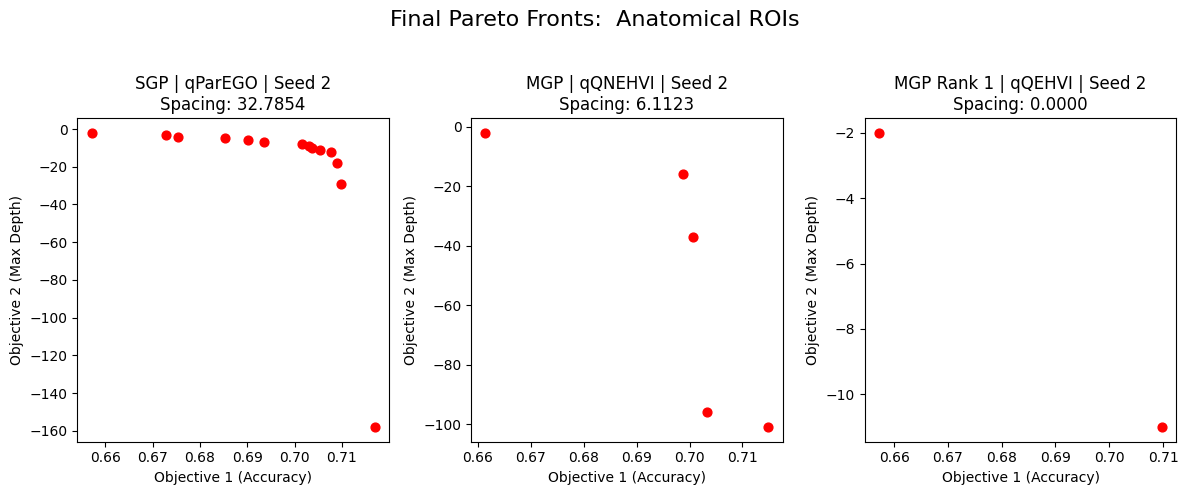

In [42]:
fig, axs = plt.subplots(1,3, figsize=(12, 5))  # 3 subplots in one row

for ax, run_df, model, seed in zip(axs, runs, models, seeds):
    acquisition = run_df['acquisition'].iloc[0]  # same for entire run

    # Get final iteration
    final_row = run_df[run_df['iteration'] == run_df['iteration'].max()].iloc[0]
    pareto = np.stack(final_row["pareto_front"], dtype=float)  # shape: (N, 2)
    print(pareto)
    # Plot in red
    ax.scatter(pareto[:, 0], pareto[:, 1], s=40, color='red')

    # Annotate each point
    # for x, y in pareto:
    #     ax.annotate(f'({x:.2f}, {y:.2f})', (x, y), textcoords="offset pixels", xytext=(5, 5), fontsize=8)

    # Compute spacing
    spacing = spacing_metric(pareto)

    # Title and labels
    ax.set_title(f'{model} | {acquisition} | Seed {seed}\nSpacing: {spacing:.4f}')
    ax.set_xlabel("Objective 1 (Accuracy)")
    ax.set_ylabel("Objective 2 (Max Depth)")

    # No grid
    ax.grid(False)

plt.suptitle("Final Pareto Fronts:  Anatomical ROIs", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

## HD


In [43]:
sgp = pd.read_parquet('./HD_SGP_combined_logs.parquet')
sgp.acquisition = sgp.acquisition.astype(str)
sgp = sgp.loc[sgp['acquisition'] == 'qParEGO', :]
for seed, df in sgp.groupby('seed'):
  df = df.loc[df['iteration'] == df['iteration'].max(), :]
  df = df.loc[df['hypervolume'] == df['hypervolume'].max(), :]
  print(f"Seed: {seed} with HV {df['hypervolume'].values}")

Seed: 0 with HV [437.42512001]
Seed: 1 with HV [432.23225294]
Seed: 2 with HV [424.39338863]
Seed: 3 with HV [436.82252439]
Seed: 4 with HV [430.84283251]


In [44]:
mgp = pd.read_parquet('./HD_MGP_combined_logs.parquet')
mgp.acquisition = mgp.acquisition.astype(str)
mgp = mgp.loc[mgp['acquisition'] == 'qQNEHVI', :]
for seed, df in mgp.groupby('seed'):
  df = df.loc[df['iteration'] == df['iteration'].max(), :]
  df = df.loc[df['hypervolume'] == df['hypervolume'].max(), :]
  print(f"Seed: {seed} with HV {df['hypervolume'].values}")

Seed: 0 with HV [435.71786035]
Seed: 1 with HV [434.55442364]
Seed: 2 with HV [426.15870733]
Seed: 3 with HV [435.02930643]
Seed: 4 with HV [434.58710146]


In [45]:
mgp = pd.read_parquet('./HD_MGPR1_combined_logs.parquet')
mgp.acquisition = mgp.acquisition.astype(str)
mgp = mgp.loc[mgp['acquisition'] == 'qQEHVI', :]
for seed, df in mgp.groupby('seed'):
  df = df.loc[df['iteration'] == df['iteration'].max(), :]
  df = df.loc[df['hypervolume'] == df['hypervolume'].max(), :]
  print(f"Seed: {seed} with HV {df['hypervolume'].values}")

Seed: 0 with HV [428.53181459]
Seed: 1 with HV [433.2391136]
Seed: 2 with HV [427.1967176]
Seed: 3 with HV [436.84197356]
Seed: 4 with HV [436.17433392]


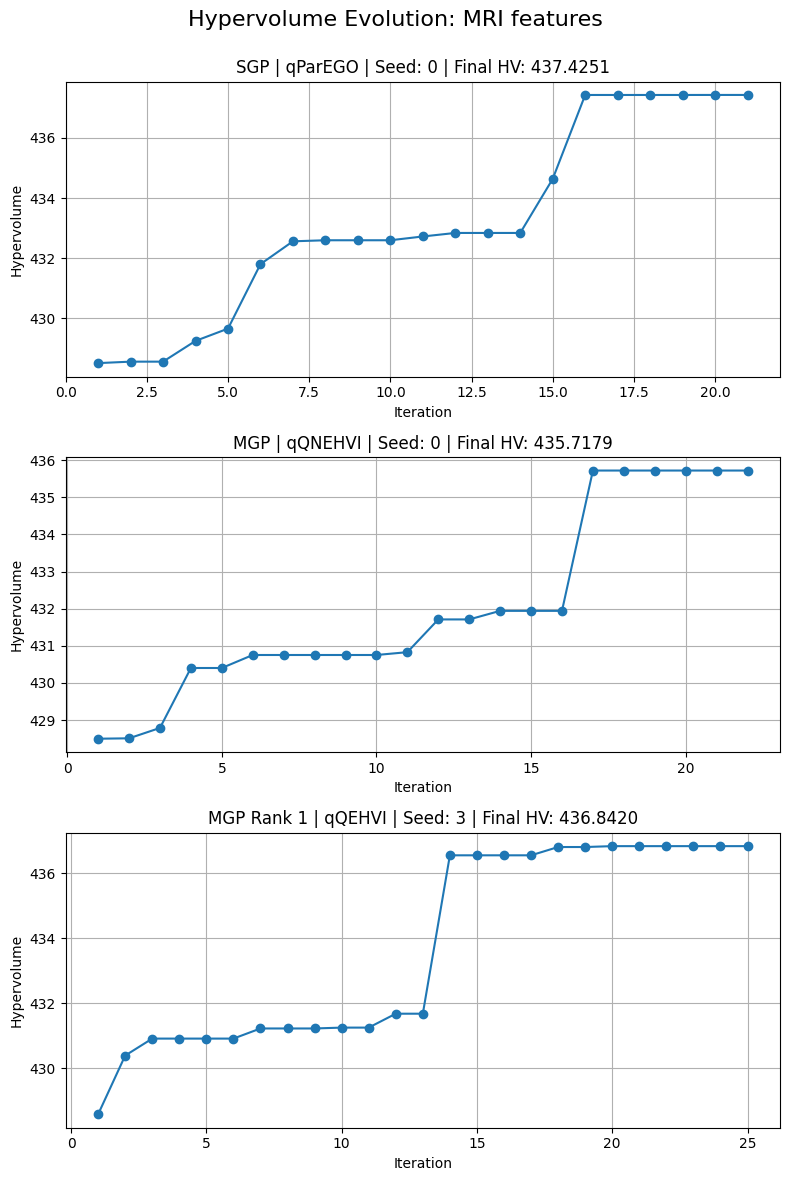

In [46]:
import pandas as pd
import matplotlib.pyplot as plt

# Load data for each model
sgp = pd.read_parquet('./HD_SGP_combined_logs.parquet')
mgp = pd.read_parquet('./HD_MGP_combined_logs.parquet')
mgp1 = pd.read_parquet('./HD_MGPR1_combined_logs.parquet')

# Filter by acquisition function
sgp = sgp[sgp['acquisition'].astype(str) == 'qParEGO']
mgp = mgp[mgp['acquisition'].astype(str) == 'qQNEHVI']
mgp1 = mgp1[mgp1['acquisition'].astype(str) == 'qQEHVI']

def get_best_run(df, model_name):
    best_seed = None
    best_final_hv = -float('inf')
    best_run_df = None

    for seed, group in df.groupby('seed'):
        max_iter = group['iteration'].max()
        final_hv = group[group['iteration'] == max_iter]['hypervolume'].max()

        if final_hv > best_final_hv:
            best_final_hv = final_hv
            best_seed = seed
            best_run_df = group[group['seed'] == seed]

    return best_run_df.sort_values('iteration'), best_seed, best_final_hv

# Get best runs
sgp_best, sgp_seed, sgp_hv = get_best_run(sgp, 'SGP')
dgp_best, dgp_seed, dgp_hv = get_best_run(mgp, 'DGP')
bnn_best, bnn_seed, bnn_hv = get_best_run(mgp1, 'BNN')

# Plotting (no sharex)
fig, axs = plt.subplots(3, 1, figsize=(8, 12))  # Removed sharex=True

models = ['SGP', 'MGP', 'MGP Rank 1']
runs = [sgp_best, dgp_best, bnn_best]
seeds = [sgp_seed, dgp_seed, bnn_seed]
hvs = [sgp_hv, dgp_hv, bnn_hv]

for ax, run_df, model, seed, hv in zip(axs, runs, models, seeds, hvs):
    acquisition = run_df['acquisition'].iloc[0]  # same for entire run
    ax.plot(run_df['iteration'], run_df['hypervolume'], marker='o')
    ax.set_title(f'{model} | {acquisition} | Seed: {seed} | Final HV: {hv:.4f}')
    ax.set_ylabel('Hypervolume')
    ax.set_xlabel('Iteration')
    ax.grid(True)

plt.suptitle("Hypervolume Evolution: MRI features\n", fontsize=16)
plt.tight_layout()
plt.show()

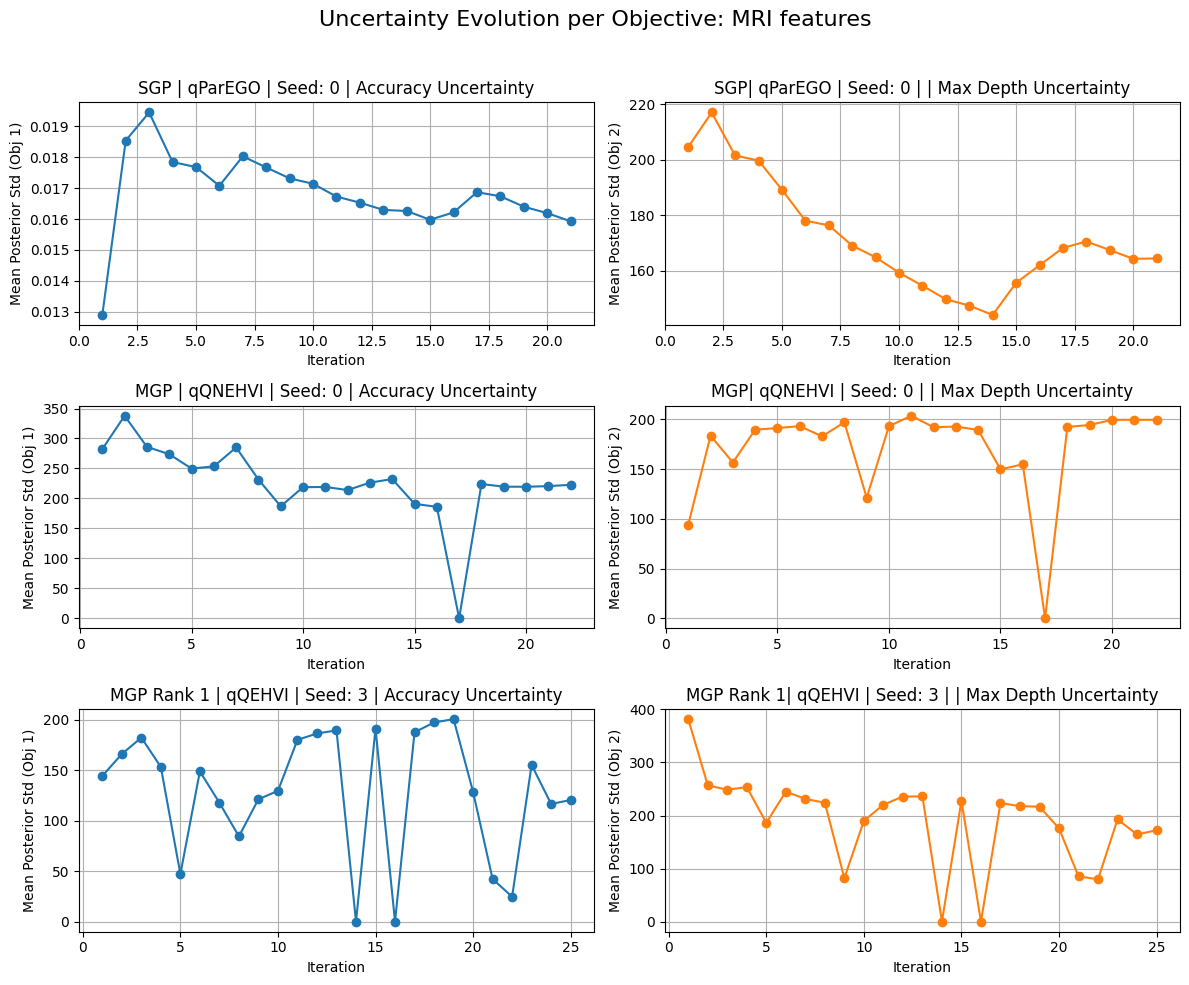

In [47]:

fig, axs = plt.subplots(3, 2, figsize=(12, 10))  # Rows = models, 2 columns for objectives

for row, (run_df, model, seed) in enumerate(zip(runs, models, seeds)):
    acquisition = run_df['acquisition'].iloc[0]  # same for entire run

    run_df = run_df[run_df["posterior_std"].notnull()]

    # Containers for each objective
    iter_to_obj1_std = {}
    iter_to_obj2_std = {}

    for _, row_data in run_df.iterrows():
        iteration = row_data["iteration"]
        stds = np.stack(row_data["posterior_std"])  # Shape: (batch_size, 2)

        obj1_mean = np.mean(stds[:, 0])  # Accuracy objective
        obj2_mean = np.mean(stds[:, 1])  # Max depth objective

        iter_to_obj1_std.setdefault(iteration, []).append(obj1_mean)
        iter_to_obj2_std.setdefault(iteration, []).append(obj2_mean)

    # Aggregate mean per iteration
    iterations = sorted(iter_to_obj1_std.keys())
    obj1_means = [np.mean(iter_to_obj1_std[i]) for i in iterations]
    obj2_means = [np.mean(iter_to_obj2_std[i]) for i in iterations]

    # Plot Objective 1 (e.g., Accuracy)
    axs[row, 0].plot(iterations, obj1_means, marker='o', color='tab:blue')
    axs[row, 0].set_title(f'{model} | {acquisition} | Seed: {seed} | Accuracy Uncertainty')

    axs[row, 0].set_ylabel('Mean Posterior Std (Obj 1)')
    axs[row, 0].set_xlabel('Iteration')
    axs[row, 0].grid(True)

    # Plot Objective 2 (e.g., Max Depth)
    axs[row, 1].plot(iterations, obj2_means, marker='o', color='tab:orange')
    axs[row, 1].set_title(f'{model}| {acquisition} | Seed: {seed} | | Max Depth Uncertainty')
    axs[row, 1].set_ylabel('Mean Posterior Std (Obj 2)')
    axs[row, 1].set_xlabel('Iteration')
    axs[row, 1].grid(True)

plt.suptitle("Uncertainty Evolution per Objective: MRI features", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

[[  0.71706721  -8.        ]
 [  0.69601838  -2.        ]
 [  0.71338033  -6.        ]
 [  0.72356632 -21.        ]
 [  0.73470502 -24.        ]
 [  0.71741015 -18.        ]]
[[   0.71706721   -8.        ]
 [   0.69601838   -2.        ]
 [   0.72449514 -159.        ]
 [   0.71937001  -22.        ]
 [   0.73776276 -229.        ]]
[[  0.69817995  -2.        ]
 [  0.73504779 -95.        ]
 [  0.71879012 -11.        ]
 [  0.72502193 -27.        ]
 [  0.72150824 -17.        ]]


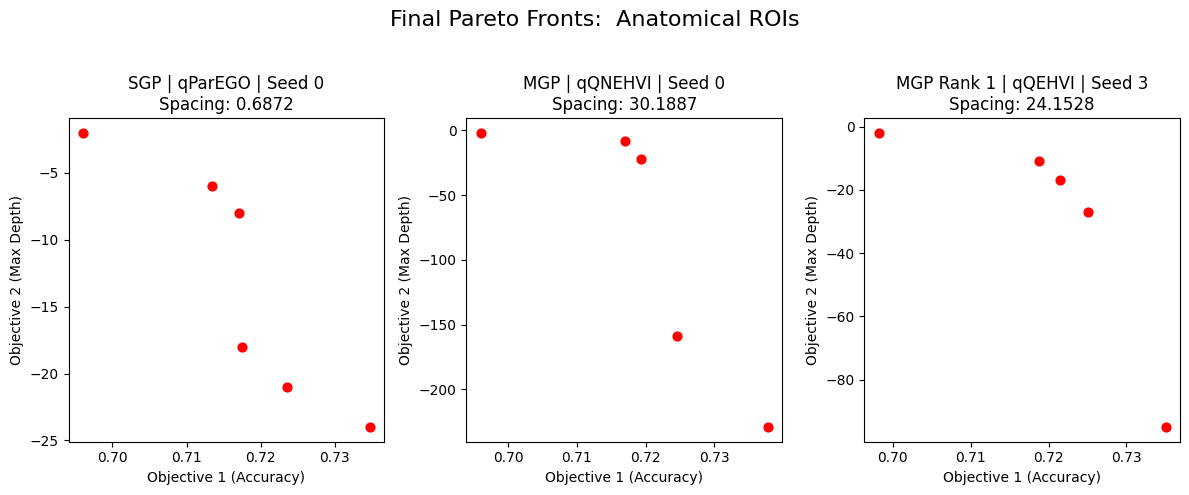

In [48]:
fig, axs = plt.subplots(1,3, figsize=(12, 5))  # 3 subplots in one row

for ax, run_df, model, seed in zip(axs, runs, models, seeds):
    acquisition = run_df['acquisition'].iloc[0]  # same for entire run

    # Get final iteration
    final_row = run_df[run_df['iteration'] == run_df['iteration'].max()].iloc[0]
    pareto = np.stack(final_row["pareto_front"], dtype=float)  # shape: (N, 2)
    print(pareto)
    # Plot in red
    ax.scatter(pareto[:, 0], pareto[:, 1], s=40, color='red')

    # Annotate each point
    # for x, y in pareto:
    #     ax.annotate(f'({x:.2f}, {y:.2f})', (x, y), textcoords="offset pixels", xytext=(5, 5), fontsize=8)

    # Compute spacing
    spacing = spacing_metric(pareto)

    # Title and labels
    ax.set_title(f'{model} | {acquisition} | Seed {seed}\nSpacing: {spacing:.4f}')
    ax.set_xlabel("Objective 1 (Accuracy)")
    ax.set_ylabel("Objective 2 (Max Depth)")

    # No grid
    ax.grid(False)

plt.suptitle("Final Pareto Fronts:  Anatomical ROIs", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()